# NLP Task: Lyrics Sentiment Analysis using Spotify & Transformers

#### In this tutorial I implement a BERT transformer with a bi-directional GRU fine-tuning layer to estimate sentiment of lyrical data. The model outputs a real number estimate between 0-1 (extremely negative to positive). 

##### You can try its predictions on your favorite song's lyrics :D

By using the pre-trained BERT transformer from [hugginface transformers library](https://github.com/huggingface/transformers) as an embedding layer, we only have to train an additional GRU layer for the sentiment analysis, regression task (outputting a point prediction instead of a class). To train the fine-tunning layer of the model, I use Spotify valence attribute on a lyrics datset. 

#### References: 
1. Pre-processing and loading a custom dataset, gaining a better understanding of hugginface: [BERT Fine-Tuning Tutorial with PyTorch By Chris McCormick and Nick Ryan](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX). 
2. Training the fine-tunning layer: [PyTorch Sentiment Analysis by Ben Trevett](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb).
3. [6.864 Natural Language Processing Spring 2020](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-864-advanced-natural-language-processing-fall-2005/) material. 

## Step 1: Import Libraries and Define Constants

I processed the dataset in [this notebook](https://colab.research.google.com/drive/17NWbYNiSXYfoCipbn9qXmkIL1SvCFOah):
1. Got songs lyrics from a Kaggle database (with columns: Band, Lyrics, Song).
2. Queried Spotify for each song [valence](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) (as a measure of positiveness).
3. Integrated to one dataframe, where each songs has a corresponding valence value, without nulls.


In [3]:
%%bash
# Check colab and silent output if there are no errors
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
# Clone Github repository 
rm -rf lyrics-sentiment
git clone https://github.com/EdenBD/lyrics-sentiment.git
# To open a function from a different notebook
pip install ipynb
# To use pre-trained BERT models
pip install transformers
# To download my model from the drive
pip install -U -q PyDrive
# Visualizations
pip install wordcloud
python -m pip install -U matplotlib
# Lyrics
pip install lyricsgenius
pip install stop-words


  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=ad7fd9c397decf3959bdad612a3ac7e23ecf33569b12d7c1663db6ae5021e7f1
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=97e4fe7ebde015e98bdae520009bc9e9b2aaca566c64138b7ec8d8b486f9172e
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


Cloning into 'lyrics-sentiment'...


In [4]:
import pandas as pd
import numpy as np
import torch

import os
import random

# For deterministic results. 
SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# For visualizations
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lyrics pre-processing
import string
from stop_words import get_stop_words

# For spotify helper function
import sys
sys.path.append('/content/lyrics-sentiment')
from helpers import get_spotify_valence, load_model, get_lyrics_from_genius, plot_training, plot_histogram

# Mount google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


#### Notebook Constants: 

If you would like to train and save your own model, approve mounting your drive and change `DRIVE_FOLDER` to your desired directory name.

The `DATASET_SIZE` is small for a shorter training cycle (took me around 3 hours without GPU), but will have less optimal results. 

In [0]:
STR_PRINT_BOUND = 600

# For supervised training of lyrics sentiments and measuring accuracy.
# below this bound, the song is considered as negative.
LOW_VALENCE_BOUND = 0.2
# above this bound, the song is considered as positive.
HIGH_VALENCE_BOUND = 0.7
# in between these bounds, the song is considered as neutral.
NEUTRAL_LOWER_BOUND = 0.35
NEUTRAL_UPPER_BOUND = 0.55

# Out of the big lyrics database, use only a few rows to decrease trainig & evaluation cycles.
DATASET_SIZE = 7000

# Make the dataset diverse by including extrmely negative,extrmely positive and neutral valence values. 
NEGATIVES_PRECENTAGE = 0.35
POSITIVES_PRECENTAGE = 0.4
NEUTRAL_PRECENTAGE = 1 - NEGATIVES_PRECENTAGE - POSITIVES_PRECENTAGE

# Split dataset to training, validation and test according to these values.
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1

# Model hyperparameters

HIDDEN_DIM = 512
LINEAR_HIDDEN = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
BATCH_SIZE = 64 

# Define used paths. 

# Update DRIVE_FOLDER to your gdrive folder.
DRIVE_FOLDER = "6864"
DRIVE_DIR = "/content/gdrive/My Drive"
ROOT_DIR = os.path.join(DRIVE_DIR,DRIVE_FOLDER)

# Save path for best epoch model. 
MODEL_NAME = "lyrics-sentiment-processed_db.pt"
SAVE_PATH = os.path.join(ROOT_DIR,MODEL_NAME)
DATASET_FILENAME = "labeled_lyrics_cleaned.csv"
PRV_MODEL_ID= "1aRKrMAh004sgWmf9S4aWDjuAPqVk60l4"
READY_MODEL_ID= "1pgCCUvpSBhFkZH2kdWDLXeK4VMIMxOVF"

# How far off an absolute difference between label and predictions counts as accurate.
ACCURACY_THRESHOLD = 0.15

## Step 2: Prepare Pytorch Dataloader

I processed the labeled lyrics dataset in [this notebook](https://colab.research.google.com/drive/17NWbYNiSXYfoCipbn9qXmkIL1SvCFOah):
1. Got songs lyrics from [250K+ lyrics Kaggle database](https://www.kaggle.com/detkov/lyrics-dataset/metadata).
2. Queried Spotify for each song [valence](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) (as a measure of positiveness).
3. Integrated to one dataframe, where each songs has a corresponding valence value, without nulls.


In [6]:

# Load lyrics with sentiment file.
dataset_path = os.path.join(ROOT_DIR,DATASET_FILENAME)

df = pd.read_csv(dataset_path, error_bad_lines=False)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Dataset size.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from dataset.
df.sample(10)

Number of training sentences: 158,353



,artist,seq,song,label
54246,Bad Religion,Three thousand miles of wilderness overcome by...,Against the Grain,0.753
57531,Anahi,El sabor del viento y tu amanecer\r\nRompe la ...,Arena Y Sol,0.771
65329,XTC,"Do something for me, boys \r\nIf I should die ...",All You Pretty Girls [Home Demo],0.961
123663,Avril Lavigne,"Hey, hey,\r\nYou, you,\r\nI don't like your gi...",Girlfriend [The Submarines' Time Warp '66 Mix],0.839
110284,Tom Waits,"My time went so quickly, \r\nI went lickety-sp...",Ol' 55,0.336
61151,Elvis Presley,Oh yes I've got a lot o' living to do\r\nA who...,Got a Lot O' Livin to Do!,0.962
107220,Jethro Tull,"Salamander, \r\nBorn in the sun-kissed flame.\...",Salamander,0.592
8348,Brian McKnight,[Nelly] \r\nLook\r\nShit just ain't the same\r...,All Night Long,0.750
135843,Neil Finn,Totally wired and the game is up\r\nI'm under ...,Rest of the Day Off,0.634
12215,Billy Stritch,It starts with one thing\r\nI don't know why\r...,Breezin' Along with the Breeze/Live Alone and ...,0.475


You can check Spotify sentiment on your choice of artist and song. 
The Kaggle dataset contains +2K artists, uploaded in October 2019. 


In [7]:
artist_name = "guetta"
song_title = "sun"

df[(df.artist.str.contains(artist_name, case=False)) & (df.label > 0.5) & (df.song.str.contains(song_title, case=False))]

,artist,seq,song,label
96293,David Guetta,"Oh wooh\nOh gonna break it, break it, break it...",Sun Goes Down,0.695
96298,David Guetta,"Let's light it up, let's light it up\r\nUntil ...",Lovers on the Sun,0.568


Out of this dataset, I took a diversified sample of size `DATASET_SIZE`, to decrease the training cycle time. 

In [8]:
neutral = (df['label'] > NEUTRAL_LOWER_BOUND) & (df['label'] < NEUTRAL_UPPER_BOUND)
positive = (df['label'] > HIGH_VALENCE_BOUND)
negative = (df['label'] < LOW_VALENCE_BOUND)

neg_size, pos_size, neutral_size = int(DATASET_SIZE*POSITIVES_PRECENTAGE), int(
    DATASET_SIZE*NEGATIVES_PRECENTAGE), int(DATASET_SIZE*NEUTRAL_PRECENTAGE)

positive_df, negative_df, neutral_df = df[positive][:neg_size], df[
                    negative][:pos_size], df[neutral][:neutral_size]

diversified_df = pd.concat([positive_df, negative_df,neutral_df], axis=0)

# Remove punctuations & stop words from sequence
stop_words = get_stop_words('english')
additional_words_to_remove = []
diversified_df.loc[:, 'seq'] = diversified_df.seq.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
diversified_df.loc[:, 'seq'] = diversified_df.seq.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


# Suffle dataframe rows and drop previous indices column
diversified_df = diversified_df.sample(frac=1).reset_index(drop=True)


lyrics = diversified_df.seq.values
labels = diversified_df.label.values

print("Diversified df example rows: \n")
print(diversified_df.sample(5))
print("Length of diversified dataset=", len(diversified_df))

Diversified df example rows: 

                       artist  ...  label
625             Guy Sebastian  ...  0.754
442           Ella Fitzgerald  ...  0.154
4073  Pete Rock & C.L. Smooth  ...  0.784
2916             Donna Summer  ...  0.948
5830                LL Cool J  ...  0.722

[5 rows x 4 columns]
Length of diversified dataset= 7000


Length avg. value: 663.81


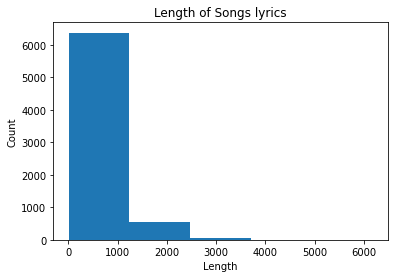

artist    0
seq       0
song      0
label     0
dtype: int64
Valence = Label avg. value: 0.49


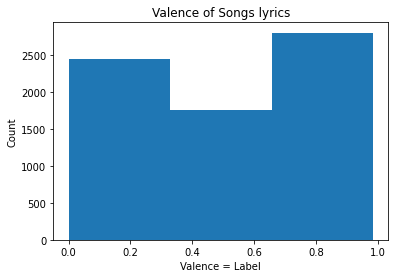

In [9]:
# Length of Songs Lyrics
songs_length = [len(seq) for seq in lyrics]
plot_histogram(songs_length, 5, 'Length', 'Count', "Length of Songs lyrics")

# Labels distribution
print(diversified_df.isnull().sum()) # should be 0
plot_histogram(labels, 3, 'Valence = Label', 'Count', "Valence of Songs lyrics")

We must tokenize the lyrical dataset, since this is what the BERT model expects as input. 
You can tokenize any text by loading the tokenizer of the imported bert model. 

In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Checking properties of Tokenizer on our dataset.

In [11]:
# Checking number of tokens in imported vocabulary. 
print("Voabulary size of Tokenizer: ",len(tokenizer.vocab),end='\n\n')

# Print the original lyrics.
print('Song lyrics: ')
print(lyrics[0][:STR_PRINT_BOUND],end='\n\n')

# Print the lyrics split into tokens.
print('Tokenized lyrics: ', tokenizer.tokenize(lyrics[0]),end='\n\n')

# Print the lyrics mapped to token ids.
token_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(lyrics[0]))
print('Tokenized IDs: ', token_ids,end='\n\n')

# Check out of vocabulary words in lyrics
print('Precentage of Unknowns: ', token_ids.count(tokenizer.unk_token_id)/len(token_ids)*100, '%',end='\n\n')

# Lyrics Sentiment
print('Label: ', labels[0])

Voabulary size of Tokenizer:  30522

Song lyrics: 
satisfied break heart never satisfied teardrops start tried shower lovin kisses ever get naggin  braggin poor heart raggin way toss heart arounds cryin shame bet like happy tearin dreams apart satisfied break heart way toss heart arounds cryin shame bet like happy tearin dreams apart Unless hurt know cried seem though ever satisfied

Tokenized lyrics:  ['satisfied', 'break', 'heart', 'never', 'satisfied', 'tear', '##drop', '##s', 'start', 'tried', 'shower', 'lo', '##vin', 'kisses', 'ever', 'get', 'na', '##gg', '##in', 'bragg', '##in', 'poor', 'heart', 'rag', '##gin', 'way', 'toss', 'heart', 'around', '##s', 'cry', '##in', 'shame', 'bet', 'like', 'happy', 'tear', '##in', 'dreams', 'apart', 'satisfied', 'break', 'heart', 'way', 'toss', 'heart', 'around', '##s', 'cry', '##in', 'shame', 'bet', 'like', 'happy', 'tear', '##in', 'dreams', 'apart', 'unless', 'hurt', 'know', 'cried', 'seem', 'though', 'ever', 'satisfied']

Tokenized IDs:  [8510

Perform tokenization on the entire dataset:
1. Convert words to voabulary indices.
2. Add special tokens to the start [CLS] and end of each song lyrics [SEP].
3. Pad & truncate all songs' lyrics to BERT max length (512 tokens).
4. Use attention masks to differentiate real tokens from padding tokens.

In [12]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every song:
for lyric in lyrics:

    #   Return a dictionary containing the encoded lyrics, after tokenization and mapping tokens to their vocabulary IDs.
    #   Add special tokens [CLS], [SEP], [PAD].
    #   Pad or truncate the sentence to max_length. 
    #   Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        lyric,                          # One song to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = tokenizer.max_len, # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its 1, 0 attention mask (0 for padding indices).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# Check Results
print("----------------------")
print('Original: ', lyrics[1])
print("----------------------")
print('Original Label: ', labels[1].item())
print("----------------------")
print('Token IDs:', input_ids[1])
print("----------------------")
print('Attention mask:', attention_masks[1])
print("----------------------")


----------------------
Original:  care wrong got intentions just hide anymore made decision pulled collar round neck bring whisper say thing wanna hear sister sister sister care wrong got intentions just hide anymore made decision put hands chest eyes filled laughter lips wet your hairs mess know just know just care wrong got intentions just hide anymore made decision care wrong got intentions just hide anymore made decision made decision Yes made decision
----------------------
Original Label:  0.46399999999999997
----------------------
Token IDs: tensor([  101,  2729,  3308,  2288, 11174,  2074,  5342,  4902,  2081,  3247,
         2766,  9127,  2461,  3300,  3288,  7204,  2360,  2518, 10587,  2963,
         2905,  2905,  2905,  2729,  3308,  2288, 11174,  2074,  5342,  4902,
         2081,  3247,  2404,  2398,  3108,  2159,  3561,  7239,  2970,  4954,
         2115, 13606,  6752,  2113,  2074,  2113,  2074,  2729,  3308,  2288,
        11174,  2074,  5342,  4902,  2081,  3247,  2729

Split data to Train, Validation, Test and create a Pytorch Iterator.

In [13]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Combine the inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Split train-validation-test sizes.
train_size = int(TRAIN_SIZE * len(dataset))
val_size = int(VALIDATION_SIZE * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset randomly.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = BATCH_SIZE

# Create DataLoaders.
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull batches sequentially.
            batch_size = batch_size 
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset), # Pull batches sequentially.
            batch_size = batch_size 
        )

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))
print('{} test samples'.format(test_size))

5600 training samples
700 validation samples
700 test samples


## Step 3: Define the Model

1. Load the same model as with the tokenizer. 
2. Build an extra layer for the sentiment task.  

To have more control on the fine-tuning final layer, I decided to define my own class. However, there are many ready-to-use, task dependent BERT such as [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification), which adds a single linear layer on top of the original [BERT model](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.Bert). 

In [14]:
from transformers import BertModel

bert = BertModel.from_pretrained('bert-base-uncased') # consists of 12 Transformer layers

Instead of training an embedding layer, I will use the pre-trained bert model weights and freeze them during fine-tuning. 

The fine-tuning layers consists of a bidirectional [GRU](https://pytorch.org/docs/stable/nn.html#gru) and linear prediction layer for sentiment output. As stated in the [paper](https://arxiv.org/pdf/1810.04805.pdf) I will only feed to the fine-tuning layers the hidden state of the final time-step.

In [0]:
import torch.nn as nn

class BERTLyricalSentimentGRU(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout, linear_hidden):
        
      super().__init__()
      
      self.bert = bert
      
      embedding_dim = bert.config.to_dict()['hidden_size'] # The hidden embedding size that bert outputs
      
      self.gru = nn.GRU(embedding_dim,
                        hidden_dim,
                        num_layers = n_layers,
                        bidirectional = bidirectional,
                        batch_first = True,
                        dropout = 0 if n_layers < 2 else dropout)
          
      self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, linear_hidden)
      # To avoid vanishing gradient and keep efficient computaions. 
      self.leaky_relu = nn.LeakyReLU()
      self.out = nn.Linear(linear_hidden, output_dim)
      
      self.dropout = nn.Dropout(dropout)

      self.initialize_weights()
      
    def forward(self, text, attention_masks):
      """
        Args:
          text(tensor): list of tokens idx, of shape (batch_size, max_sentence_len)
          attention_masks(tensor): marks padding tokens.
      """
      # print("text.shape=",text.shape) # (batch_size, max_sentence_len)
      # Freezed embedding weights        
      with torch.no_grad():
          embedded = self.bert(input_ids=text, attention_mask=attention_masks)[0] 
              
      # print("embedded.shape=",embedded.shape) #(batch_size, max_sentence_len, embed_dim)
      
      _, hidden = self.gru(embedded) # Do not need the outputs of the last (depth-wise) layer 
      # print("hidden.shape before GRU=",hidden.shape) #(n_layers * n_directions, batch_size, embed_dim)
      
      # Use final time-step of the last GRU layer as linear layer input.
      if self.gru.bidirectional:
          hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)) 
      else:
          hidden = self.dropout(hidden[-1,:,:])

      # print("hidden.shape after GRU=",hidden.shape) #(batch_size, hidden_dim *2 OR hidden_dim)
     
      linear_hidden = self.leaky_relu(self.linear(hidden))
      output = self.out(linear_hidden)        
      
      # print("output.shape=",output.shape) #(batch_size, linear_dim)     
      
      return output

    def initialize_weights(self):
      for name, param in self.gru.named_parameters():                
        if (param.requires_grad and ('weight' in name)):
          torch.nn.init.xavier_normal_(param, gain=1.0)


In [0]:
model = BERTLyricalSentimentGRU(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT,
                         LINEAR_HIDDEN)

Freeze BERT parameters and check learnable parameters that will be updated dduring training.

In [0]:
# Freeze parameters of bert model
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [18]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

gru.weight_ih_l0
gru.weight_hh_l0
gru.bias_ih_l0
gru.bias_hh_l0
gru.weight_ih_l0_reverse
gru.weight_hh_l0_reverse
gru.bias_ih_l0_reverse
gru.bias_hh_l0_reverse
gru.weight_ih_l1
gru.weight_hh_l1
gru.bias_ih_l1
gru.bias_hh_l1
gru.weight_ih_l1_reverse
gru.weight_hh_l1_reverse
gru.bias_ih_l1_reverse
gru.bias_hh_l1_reverse
linear.weight
linear.bias
out.weight
out.bias
The model has 8,925,697 trainable parameters


## Step 4: Train the Model

#### MARE Custom Loss function

I considered a few loss function, but eventually decided to use a custom loss function I called MRAE (mean root absolute error).
It is very similar to MAE. The only difference is that I take the square root of each absolute difference, to have a higher loss for bigger differences. 

I chose this loss over others for the following reasons: 
1. The model outputs a point prediction - a particular sentiment, and not a probability distribution, as cross entropy requires.
2. The model outputs small values in the range [0-1]. Therefore, MSE would have decreased the error value instead of increasing it (since x^2 < x when x is a proper fraction, [as explained here](https://math.stackexchange.com/questions/2618094/why-the-square-root-of-any-decimal-number-between-0-and-1-always-come-out-to-be)). 

Optimal Prediction: For several lyrics examples with a similar embedding the model's optimal prediction is their median label. 

Implemetation:
1. For a more numerically stable result I apply Sigmoid after the forward pass, as part of the loss computation. 
2. For building a custom loss function I followed [this discussion](https://discuss.pytorch.org/t/rmse-loss-function/16540/3). 

#### ADAMW Optimizer

Adam with weight decay Regularization as proposed in [this paper](https://arxiv.org/abs/1711.05101) which improves Adam's generalization performance.



In [0]:
import torch.optim as optim

# The call to model.parameters() contains the learnable parameters.
optimizer = optim.AdamW(model.parameters())

In [0]:
sigmoid = nn.Sigmoid()

class MARELoss(nn.Module):
    def __init__(self):
      super().__init__()
      # Since the square root is not differentiable at zero
      self.eps = 1e-6
        
    def forward(self, predicted_logits, y):
      yhat = sigmoid(predicted_logits)
      return torch.mean(torch.sqrt(torch.abs(yhat - y) + self.eps))

criterion = MARELoss()

Check if any GPUs are available, and if available, put the model and criterion onto the GPU.

In [21]:
# If there's a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('There are {} GPU(s) available'.format(torch.cuda.device_count()))

# Convert model parameters to double
model.double()

# Fit model and criterion to Cuda
model = model.to(device)
criterion = criterion.to(device)


There are 0 GPU(s) available


Compute the accuracy of a batch and track predictions of the three different buckets: negative, neutral and positive sentiment. I use the threshold (hyperparameter) as an absolute difference that the prediction can have from the label.

In [0]:
def batch_accuracy(predicted_logits, labels, threshold=ACCURACY_THRESHOLD):
    """
    Args: 
      preds and labels are both (batch_size,). 
      predicted_logits are still logits, before sigmoid was applied.
      labels are between [0-1].

    Returns a float between 0-1, represents precentage of correct predictions in batch. 
    A correct a prediction for which abs(prediction-label) <=  threshold.
    """
    # Move to CPU to be able to use numpy.
    preds = sigmoid(predicted_logits)
    preds = preds.detach().cpu().numpy()
    labels = labels.to('cpu').numpy()
    # Filter all the correct predictions, corrrect are close enough to the labels.
    correct_mask = np.isclose(preds, labels, rtol=threshold, atol=threshold)
    # Get indices of correct predictions.
    correct_indices = correct_mask.nonzero()
    correct_labels = labels[correct_indices]
    # Correct bounds because of threshold 
    negative_upper_bound = threshold + LOW_VALENCE_BOUND 
    positive_lower_bound = HIGH_VALENCE_BOUND - threshold
    # Precentage of correct sentiment out of all the labels with this sentiment range.
    # None if none of the batch labels are at this range 
    negative_labels, positive_labels = labels[labels < negative_upper_bound], labels[labels > positive_lower_bound]
    length_neutral_labels = len(labels) - len(negative_labels) - len(positive_labels)
    correct_negative = None if len(negative_labels) == 0 else round(np.count_nonzero(correct_labels < negative_upper_bound)/len(negative_labels),3)
    correct_positive = None if len(positive_labels) == 0 else round(np.count_nonzero(correct_labels > positive_lower_bound)/len(positive_labels),3)
    correct_neutral = None if length_neutral_labels == 0 else round(np.count_nonzero((negative_upper_bound <= correct_labels) & (correct_labels <= positive_lower_bound))/length_neutral_labels,3)

    return np.sum(correct_mask) / len(labels), correct_negative, correct_positive, correct_neutral

Most of the training code is taken from the above mentioned [PyTorch Sentiment Analysis by Ben Trevett](https://github.com/bentrevett/pytorch-sentiment-analysis). 

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_negative, epoch_positive, epoch_neutral = 0, 0, 0
    
    model.train()
    
    for batch_id, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        # batch contains three pytorch tensors:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        predictions_logits = model(b_input_ids, attention_masks=b_input_mask).squeeze(1)
        loss = criterion(predictions_logits, b_labels)
        
        acc, correct_negative, correct_positive,correct_neutral = batch_accuracy(predictions_logits, b_labels)
        
        loss.backward()

        # Check if gradients are exploding/ vanishing:
        # for name, param in model.named_parameters():                
        #   if (param.requires_grad and ('weight' in name)):
            # print('{} gradient: {} \n'.format(name,param.grad.data.norm(2).item()))
        
        optimizer.step()

        print("Trained batch number: {}   | loss: {:.2f} | accuracy: {:.2f}".format(batch_id, loss.item(), acc.item()))
        print("Predicted correctly:    {} negatives | {} positives | {} neutral".format(
            correct_negative, correct_positive, correct_neutral))

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_negative += 0 if correct_negative is None else correct_negative
        epoch_positive += 0 if correct_positive is None else correct_positive
        epoch_neutral += 0 if correct_neutral is None else correct_neutral

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_negative/ len(iterator), epoch_positive/ len(iterator), epoch_neutral/ len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_negative, epoch_positive,epoch_neutral = 0, 0, 0

    
    model.eval()
    
    with torch.no_grad():
    
        for batch_id, batch in enumerate(iterator):

            # batch contains three pytorch tensors:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            predictions_logits = model(b_input_ids, attention_masks=b_input_mask).squeeze(1)            
            loss = criterion(predictions_logits, b_labels)
        
            acc, correct_negative, correct_positive,correct_neutral = batch_accuracy(predictions_logits, b_labels)

            print("Evaluated batch number: {}   | loss: {:.2f} | accuracy: {:.2f}".format(batch_id, loss.item(), acc.item()))
            print("Predicted correctly:    {} negatives | {} positives | {} neutral".format(
            correct_negative, correct_positive, correct_neutral))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_negative += 0 if correct_negative is None else correct_negative
            epoch_positive += 0 if correct_positive is None else correct_positive
            epoch_neutral += 0 if correct_neutral is None else correct_neutral

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_negative/ len(iterator), epoch_positive/ len(iterator), epoch_neutral/len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [72]:
# The BERT authors recommend between 2 to 4 epochs.

N_EPOCHS = 3

best_valid_loss = float('inf')
epochs_val_loss = []
epochs_accuracy = []
epochs_pos_acc, epochs_neg_acc, epochs_neutral_acc = [], [], []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc, train_negative, train_positive, train_neutral = train(
        model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_negative, valid_positive, valid_neutral = evaluate(
        model, validation_dataloader, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Save Model with loss {:.2f} to {}".format(best_valid_loss, SAVE_PATH))
        save_output = open(SAVE_PATH, mode="wb")
        torch.save(model.state_dict(), save_output)

    # Add values to graph
    epochs_val_loss.append(valid_loss)
    epochs_accuracy.append(valid_acc)
    epochs_pos_acc.append(valid_positive)
    epochs_neg_acc.append(valid_negative)
    epochs_neutral_acc.append(valid_neutral)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Correct Neg: {train_negative*100:.2f}% Pos: {train_positive*100:.2f}% | Neutral: {train_neutral*100:.2f}%')
    print(f'\t  Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Correct Neg: {valid_negative*100:.2f}% Pos: {valid_positive*100:.2f}% | Neutral: {valid_neutral*100:.2f}%')

Trained batch number: 0   | loss: 0.50 | accuracy: 0.31
Predicted correctly:    0.0 negatives | 0.231 positives | 1.0 neutral
Trained batch number: 1   | loss: 0.50 | accuracy: 0.23
Predicted correctly:    0.0 negatives | 0.0 positives | 1.0 neutral
Trained batch number: 2   | loss: 0.55 | accuracy: 0.42
Predicted correctly:    1.0 negatives | 0.0 positives | 0.611 neutral
Trained batch number: 3   | loss: 0.50 | accuracy: 0.30
Predicted correctly:    0.069 negatives | 0.308 positives | 1.0 neutral
Trained batch number: 4   | loss: 0.46 | accuracy: 0.48
Predicted correctly:    1.0 negatives | 0.13 positives | 0.0 neutral
Trained batch number: 5   | loss: 0.48 | accuracy: 0.48
Predicted correctly:    0.12 negatives | 0.704 positives | 0.75 neutral
Trained batch number: 6   | loss: 0.52 | accuracy: 0.45
Predicted correctly:    0.0 negatives | 1.0 positives | 0.05 neutral
Trained batch number: 7   | loss: 0.50 | accuracy: 0.50
Predicted correctly:    0.05 negatives | 0.967 positives | 0.1

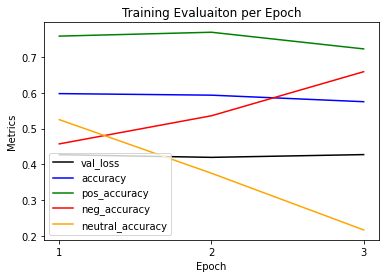

[0.42681789211674614, 0.41938308584580386, 0.4271045679181146] [0.5975378787878788, 0.5931818181818183, 0.5749053030303031] [0.7581818181818182, 0.769, 0.7224545454545453] [0.4569999999999999, 0.5356363636363637, 0.6587272727272727] [0.5247272727272727, 0.375, 0.21663636363636363]


In [86]:
# Plot loss validation vs accuracy accross epochs
plot_training(3, epochs_val_loss, epochs_accuracy, epochs_pos_acc, epochs_neg_acc, epochs_neutral_acc)
print(epochs_val_loss, epochs_accuracy, epochs_pos_acc, epochs_neg_acc, epochs_neutral_acc)

Load the best model across epochs, the one that has the lowest validation loss.  Done by using `load_state_dict` which will update the given `model` in-place.

The preset is to load a previously trained model. 
If you would like to use yours, please change `use_trained_model` to True.

Downloading the ready model will take a few minutes and will require your authentication when propmpted. 

In [56]:
# Load newly trained model, in place updates given `model`.
# load_model(model=model, shared_file_id=None, path=SAVE_PATH, use_trained_model=True,colab=True)
# Load ready to use model, does not require training again.
load_model(model=model, shared_file_id=READY_MODEL_ID, path=MODEL_NAME, use_trained_model=False,colab=True)
model.eval()
model.zero_grad()

Downloaded model Successfully
Loaded the ready-to-use model Successfully


Check model performance on test set. 

In [87]:

test_loss, test_acc, correct_negative, correct_positive, correct_neutral = evaluate(model, test_dataloader, criterion)
print("Test Loss: {:.2f} | Test Accuracy: {:.2f}%".format(test_loss, 100*test_acc))
print("--------------------------------------------------------")
print("Predicted correctly: {:.2f}% negatives | {:.2f}% positives | {:.2f}% neutral".format(correct_negative*100, correct_positive*100, correct_neutral*100))


Evaluated batch number: 0   | loss: 0.39 | accuracy: 0.66
Predicted correctly:    0.875 negatives | 0.852 positives | 0.238 neutral
Evaluated batch number: 1   | loss: 0.41 | accuracy: 0.59
Predicted correctly:    0.517 negatives | 0.95 positives | 0.267 neutral
Evaluated batch number: 2   | loss: 0.42 | accuracy: 0.56
Predicted correctly:    0.75 negatives | 0.75 positives | 0.0 neutral
Evaluated batch number: 3   | loss: 0.44 | accuracy: 0.59
Predicted correctly:    0.6 negatives | 0.833 positives | 0.3 neutral
Evaluated batch number: 4   | loss: 0.40 | accuracy: 0.66
Predicted correctly:    0.63 negatives | 0.815 positives | 0.3 neutral
Evaluated batch number: 5   | loss: 0.37 | accuracy: 0.69
Predicted correctly:    0.682 negatives | 0.875 positives | 0.444 neutral
Evaluated batch number: 6   | loss: 0.38 | accuracy: 0.61
Predicted correctly:    0.733 negatives | 0.789 positives | 0.133 neutral
Evaluated batch number: 7   | loss: 0.44 | accuracy: 0.50
Predicted correctly:    0.6 ne

## Step 5: Interpretation with visualizations


In [0]:
def predict_tokens(input_ids_tensor, attention_mask_tensor, model):  
    prediction = model(input_ids_tensor, attention_mask_tensor).squeeze(1) # in place remove all size 1 in the given dimension (here 1).
    prediction = torch.sigmoid(prediction)
    return prediction.item()

def predict_lyrics_sentiment(model, tokenizer, lyrics, label=None):
    model.eval()
    # Turn lyrics to voacbulary indices.
    input_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(lyrics))
    text = torch.LongTensor(input_ids).reshape(1,-1)

    # Create a mask for input's padding.
    mask = torch.LongTensor(np.where(input_ids == 0, 0, 1)).reshape(1,-1)
    return predict_tokens(text, mask, model)


In [29]:
def predict_baseline(model, tokenizer, length=tokenizer.max_len):
  model.eval()
  # Turn lyrics to voacbulary indices.
  pad = tokenizer.pad_token_id
  baseline = torch.LongTensor([pad]*length).reshape(1,-1)

  # Create a mask for input's padding.
  mask = torch.LongTensor([0]*length).reshape(1,-1)

  prediction = model(baseline, attention_masks=mask).squeeze(1) # in place remove all size 1 in the given dimension (here 1).
  prediction = torch.sigmoid(prediction)
  return prediction.item()

baseline_pred = predict_baseline(model, tokenizer)
print('Baseline prediction: ',baseline_pred)

Baseline prediction:  0.5849168844794767


In [0]:
def plot_wordcolor(frequencies, positive_diff, negative_diff):

  def color_function(word, *args, **kwargs):
    if word in negative_diff:
      return 'rgb(255,0,0)' # red
    elif word in positive_diff:
      return 'rgb(0,255,0)' # green
    else:
      return 'rgb(255,255,255)' #white
    # otherwise returns grey
  
  # Words with twice the difference will be twice as large
  wc = WordCloud(background_color='black',max_words=len(frequencies.keys()), max_font_size=120, 
                 collocations=False, width=600,height=400,
                        relative_scaling=1,color_func=color_function).generate_from_frequencies(frequencies)


  plt.imshow(wc,
           interpolation="bilinear")
  
  plt.axis("off")
  plt.show()


def check_words_effect(model, tokenizer,lyrics):
  # Get tokens and mask from lyrics
  lyrics_word_list = tokenizer.tokenize(lyrics)
  input_ids = tokenizer.convert_tokens_to_ids(lyrics_word_list)
  input_ids_tensor = torch.LongTensor(input_ids).reshape(1,-1)
  mask_tensor = torch.LongTensor(np.where(input_ids == 0, 0, 1)).reshape(1,-1)
  all_tokens_pred = predict_tokens(input_ids_tensor, mask_tensor, model)
  # Remove one token at a time
  unique_ids = set(input_ids)
  id_delta_abs = {}
  positive_diff, negative_diff = set(), set()

  print("Calculating {} unique tokens effects.\n".format(len(unique_ids)))
  for token_id in unique_ids:
    input_ids = np.array(input_ids)
    input_ids_without_token = input_ids[input_ids != token_id]
    input_ids_without_token_tensor = torch.LongTensor(input_ids_without_token).reshape(1,-1)
    mask_without_token = torch.LongTensor(np.where(input_ids_without_token == 0, 0, 1)).reshape(1,-1)
    without_token_pred = predict_tokens(input_ids_without_token_tensor, mask_without_token, model)
    word = tokenizer.convert_ids_to_tokens(token_id)

    delta = all_tokens_pred - without_token_pred
    # If the prediction decresed without the word, the word was positive
    no_diff = 0.00001
    delta = 0 if abs(delta) < no_diff else delta
    if delta > 0:
      positive_diff.add(word)
    elif delta < 0:
      negative_diff.add(word)
    # For frequency/importance analysis
    id_delta_abs[word] = abs(delta)*100
  
  print("Plotting word color\n")
  plot_wordcolor(id_delta_abs, positive_diff, negative_diff)

  

## Step 6: Predict unseen samples

Time to try out the model ! Test the sentiment of lyrics from the given dataset or your own. 

Before passing lyrical text through the model, we will convert the input text to vocabulary indices, add special tokens and convert it to a reshaped tensor.

#### Low valence Sample

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Low valence lyrical sentiment analysis:
-----------------
Name: More
Artist: Junkie XL
-----------------
Lyrics extract:
Roll more, rock more
Roll more, rock more
Roll more
Rock, rock, rock, rock

Roll more, rock more
Roll more, rock more
Roll more, rock more
Roll more, rock more

Roll more
Rock, rock, rock, rock
Rock, rock, rock, rock
Rock, rock, rock, rock

Rock, rock, rock, rock
Rock, rock, rock, rock
Rock, rock, rock, rock
Pac-Man is loving it

Rock more, roll more
Fuck more, Pac-Man is loving it
Rock more, roll more
Fuck more, Pac-Man is loving it

A cloudy vision, absence of granter
I don't care what is wrong or right
The earth is bleeding and secreeding madness
Petrified, gone 
-----------------
Model Prediction: 0.78
Spotify Label: 0.19
Calculating 102 unique tokens effects.

Plotting word color



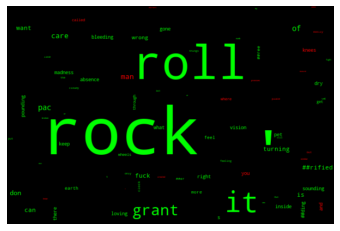

In [35]:
# Make sure not taken from dataset used for training
negative_sample_row = df[DATASET_SIZE+1:][df.label<LOW_VALENCE_BOUND].sample()
negative_sample_row_lyrics = negative_sample_row['seq'].item()
print("Low valence lyrical sentiment analysis:")
print("-----------------")
print("Name:", negative_sample_row.song.item())
print("Artist:", negative_sample_row.artist.item())
print("-----------------")
print("Lyrics extract:")
print(negative_sample_row_lyrics[:STR_PRINT_BOUND])

prediction = predict_lyrics_sentiment(model, tokenizer, negative_sample_row_lyrics)
print("-----------------")
print("Model Prediction: {:.2f}".format(prediction))
neg_label = negative_sample_row.label.item()
print("Spotify Label: {:.2f}".format(neg_label))

check_words_effect(model, tokenizer,negative_sample_row_lyrics)


#### High valence Sample 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


High valence lyrical sentiment analysis:
-----------------
Name: I Can't Give You Anything But Love
Artist: Muggsy Spanier
-----------------
Lyrics extract:
Gee, but it's tough to be broke, kid.
It's not a joke, kid, it's a curse.
My luck is changing, it's gotten from 
simply rotten to something worse
Who knows, some day I will win too. 
I'll begin to reach my prime.

Now though I see what our end is,
All I can spend is just my time.

I can't give you anything but love, baby.
That's the only thing I've plenty of,baby.

Dream awhile, scheme awhile
We're sure to find

Happiness and I guess
All those things you've always pined for.

Gee I'd like to see you looking swell, baby.
Diamond bracelets Woolworth doesn't sell, baby.

Til
-----------------
Model Prediction: 0.75
Spotify Label: 0.79
Calculating 125 unique tokens effects.

Plotting word color



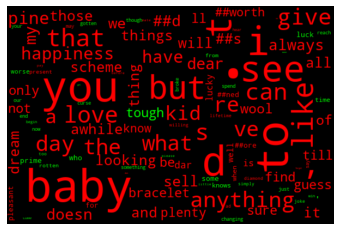

In [36]:
pos_sample_row = df[DATASET_SIZE+1:][df.label>HIGH_VALENCE_BOUND].sample()
pos_sample_row_lyrics = pos_sample_row['seq'].item()

print("High valence lyrical sentiment analysis:")
print("-----------------")
print("Name:", pos_sample_row.song.item())
print("Artist:", pos_sample_row.artist.item())
print("-----------------")
print("Lyrics extract:")
print(pos_sample_row_lyrics[:STR_PRINT_BOUND])

prediction = predict_lyrics_sentiment(model, tokenizer, pos_sample_row_lyrics)
print("-----------------")
print("Model Prediction: {:.2f}".format(prediction))
print("Spotify Label: {:.2f}".format(pos_sample_row.label.item()))

check_words_effect(model, tokenizer,pos_sample_row_lyrics)


#### Your own example

In [0]:
genius_token = "YOUR_GENIUS_TOKEN_HERE"
# Get a token by pressing "Get token" here https://developer.spotify.com/console/get-audio-features-track
# Spotify_token = "YOUR_TOKEN"
spotify_token = "SPOTIFY_TOKEN"

def new_song_prediction(model, tokenizer, artist, song_title, spotify_token, genius_token, visualize= False): 
  lyrics = get_lyrics_from_genius(song_title, artist, genius_token)
  # remove punctuation
  lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
  
  prediction = predict_lyrics_sentiment(model, tokenizer, lyrics)
  print("-----------------------")
  print("Model Prediction: {:.2f}".format(prediction))
  print("-----------------------\n")

  print("---------------------------------------------------------------------")
  spotify_label = get_spotify_valence(song_title,artist,spotify_token)
  print("---------------------------------------------------------------------\n")
  if visualize:
    check_words_effect(model, tokenizer, lyrics)


Searching for "down" by Jay sean...
Done.
-----------------------
Model Prediction: 0.78
-----------------------

---------------------------------------------------------------------
Found valence: 0.68 of the song: down - Jay sean
---------------------------------------------------------------------

Calculating 121 unique tokens effects.

Plotting word color



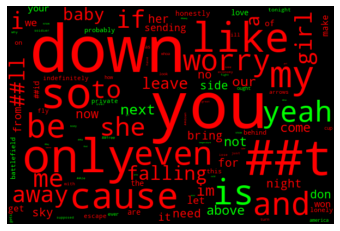

In [54]:
song_title = "down"
artist = "Jay sean"
new_song_prediction(model, tokenizer, artist, song_title, spotify_token, genius_token, visualize= True)

Searching for "breathin" by Ariana Grande...
Done.
-----------------------
Model Prediction: 0.78
-----------------------

---------------------------------------------------------------------
Found valence: 0.36 of the song: breathin - Ariana Grande
---------------------------------------------------------------------

Calculating 112 unique tokens effects.

Plotting word color



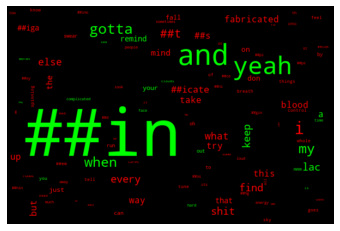

In [39]:
song_title = "breathin"
artist = "Ariana Grande"
new_song_prediction(model, tokenizer, artist, song_title, spotify_token, genius_token, visualize= True)